Converged after 5037 iterations


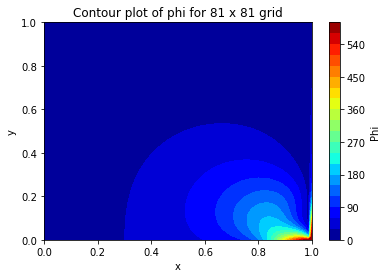

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
L = 1.0  # Length of the domain
nx, ny = 81, 81  # Number of grid points in x and y
dx = L / (nx - 1)
dy = L / (ny - 1)
max_iter = 10000  # Maximum number of iterations
tolerance = 1e-6  # Convergence tolerance

# Source term function
def source_term(x, y):
    return 50000 * np.exp(-50 * ((1 - x) ** 2 + y ** 2)) * (100 * ((1 - x) ** 2 + y ** 2) - 2)

# Boundary conditions
def phi_bc(x, y, side):
    if side == 'left':
        return 500 * np.exp(-50 * (1 + y ** 2))
    elif side == 'right':
        return 100 * (1 - y) + 500 * np.exp(-50 * y ** 2)
    elif side == 'bottom':
        return 100 * x + 500 * np.exp(-50 * (1 - x) ** 2)
    elif side == 'top':
        return 500 * np.exp(-50 * ((1 - x) ** 2 + 1))

# TDMA solver for tridiagonal system
def tdma(a, b, c, d):
    n = len(d)
    cp = np.zeros(n)
    dp = np.zeros(n)

    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]

    for i in range(1, n):
        denom = b[i] - a[i] * cp[i - 1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i] * dp[i - 1]) / denom

    x = np.zeros(n)
    x[-1] = dp[-1]
    for i in range(n - 2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i + 1]

    return x

# Initialize the solution field
phi = np.zeros((ny, nx))

# Set boundary conditions
x = np.linspace(0, L, nx)
y = np.linspace(0, L, ny)

for j in range(ny):
    phi[j, 0] = phi_bc(0, y[j], 'left')      # Left boundary
    phi[j, -1] = phi_bc(1, y[j], 'right')    # Right boundary

for i in range(nx):
    phi[0, i] = phi_bc(x[i], 0, 'bottom')    # Bottom boundary
    phi[-1, i] = phi_bc(x[i], 1, 'top')      # Top boundary

# Iterative solution using line-by-line TDMA (row sweep)
for iteration in range(max_iter):
    phi_old = np.copy(phi)
    for j in range(1, ny-1):  # Sweep through rows (y-direction)
        a = np.ones(nx-2) / dx**2  # Coefficients for TDMA
        b = -2 * (1/dx**2 + 1/dy**2) * np.ones(nx-2)
        c = np.ones(nx-2) / dx**2
        d = -source_term(x[1:-1], y[j])

        # Add the phi values from the neighboring points (y-direction)
        d -= (phi[j+1, 1:-1] + phi[j-1, 1:-1]) / dy**2

        # Solve the tridiagonal system for the current row
        phi[j, 1:-1] = tdma(a, b, c, d)

    # Check for convergence
    error = np.linalg.norm(phi - phi_old)
    if error < tolerance:
        print(f'Converged after {iteration+1} iterations')
        break

# Plot the final solution
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, phi, 20, cmap='jet')
plt.colorbar(label='Phi')
plt.title(f'Contour plot of phi for {nx} x {ny} grid')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
